In [455]:
import numpy as np

import pandas as pd


In [456]:
def cargar_imagen_p2(path):
    with open(path, 'r') as f:
        # Verificar que es un archivo PGM P2
        assert f.readline().strip() == 'P2', "Formato de archivo no soportado o archivo no es PGM P2"
        
        # Leer y omitir líneas de comentarios
        linea = f.readline().strip()
        while linea.startswith('#'):
            linea = f.readline().strip()
        
        # Leer dimensiones
        dimensiones = linea.split()
        ancho, alto = int(dimensiones[0]), int(dimensiones[1])
        
        # Leer valor máximo de píxel (se asume 255)
        maxval = int(f.readline().strip())
        assert maxval == 255, "Este ejemplo solo soporta imágenes con maxval=255"
        
        # Leer todos los datos de imagen restantes
        datos = [int(line.strip()) for line in f if line.strip()]  # Leer y convertir cada línea
        
        if len(datos) != ancho * alto:
            raise ValueError(f"El número de datos ({len(datos)}) no coincide con las dimensiones especificadas ({ancho}x{alto}).")

        imagen = np.array(datos, dtype=np.uint8).reshape((alto, ancho))
        
        return imagen / maxval  # Normalizar a rango [0, 1]

In [457]:
def guardar_imagen(path, imagen):
    alto, ancho = imagen.shape
    maxval = 255
    header = f"P5\n{ancho} {alto}\n{maxval}\n".encode('ascii')
    with open(path, 'wb') as f:
        f.write(header)
        np.array(imagen * maxval, dtype=np.uint8).tofile(f)

In [458]:
def umbral_simple(imagen, umbral):
    return (imagen > umbral).astype(int)

In [459]:
def otsu(imagen):
    varianza_max = 0
    umbral_optimo = 0.1
    for t in np.linspace(0, 1, 300):
        primer_grupo = imagen[imagen <= t]
        segundo_grupo = imagen[imagen > t]
        peso1 = len(primer_grupo) / len(imagen.flatten())
        peso2 = len(segundo_grupo) / len(imagen.flatten())
        media1 = np.mean(primer_grupo) if primer_grupo.size > 0 else 0
        media2 = np.mean(segundo_grupo) if segundo_grupo.size > 0 else 0
        
        varianza_interclase = peso1 * peso2 * (media1 - media2) ** 2
        if varianza_interclase > varianza_max:
            varianza_max = varianza_interclase
            umbral_optimo = t

    return (imagen > umbral_optimo).astype(np.uint8)

In [460]:
def binarizacion_local(imagen, ventana=10, C=0.5):
    imagen_bin = np.zeros_like(imagen)
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            # Ajustar los límites para asegurar el tamaño correcto de la ventana
            x0, x1 = max(i - ventana // 2, 0), min(i + ventana // 2 + 1, imagen.shape[0])
            y0, y1 = max(j - ventana // 2, 0), min(j + ventana // 2 + 1, imagen.shape[1])
            ventana_local = imagen[x0:x1, y0:y1]
            umbral_local = ventana_local.mean() - C * ventana_local.std()  # Ajuste dinámico basado en la std local
            imagen_bin[i, j] = 1 if imagen[i, j] > umbral_local else 0
    return imagen_bin

In [461]:
def calcular_metricas(prediccion, verdad):
    tp = np.sum((prediccion == 1) & (verdad == 1))
    tn = np.sum((prediccion == 0) & (verdad == 0))
    fp = np.sum((prediccion == 1) & (verdad == 0))
    fn = np.sum((prediccion == 0) & (verdad == 1))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if tp + fn else 0
    specificity = tn / (tn + fp) if tn + fp else 0
    precision = tp / (tp + fp) if tp + fp else 0
    f1_score = 2 * precision * sensitivity / (precision + sensitivity) if precision + sensitivity else 0
    
    return accuracy, sensitivity, specificity, precision, f1_score

In [462]:
# Inicializar DataFrame para almacenar resultados
columnas = ['Imagen', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
resultados_simple = pd.DataFrame(columns=columnas)
resultados_otsu = pd.DataFrame(columns=columnas)
resultados_local = pd.DataFrame(columns=columnas)

# Listas para almacenar las imágenes binarizadas
imagenes_pred_simple = []
imagenes_pred_otsu = []
imagenes_pred_local = []

for i in range(1, 21):  # Imágenes del 1 al 20
    imagen_path = f"images/{i}.pgm"
    gt_path = f"images/{i}_gt.pgm"
    imagen = cargar_imagen_p2(imagen_path)
    imagen_gt = cargar_imagen_p2(gt_path)
    
    # Umbral Simple
    imagen_bin_simple = umbral_simple(imagen, 0.35)  # Umbral ejemplo
    metricas = calcular_metricas(imagen_bin_simple, imagen_gt)
    resultados_simple = resultados_simple.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
    imagenes_pred_simple.append(imagen_bin_simple)
    
    # Otsu
    imagen_bin_otsu = otsu(imagen)
    metricas = calcular_metricas(imagen_bin_otsu, imagen_gt)
    resultados_otsu = resultados_otsu.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
    imagenes_pred_otsu.append(imagen_bin_otsu)
    
    # Binarización Local
    imagen_bin_local = binarizacion_local(imagen)
    metricas = calcular_metricas(imagen_bin_local, imagen_gt)
    resultados_local = resultados_local.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
    imagenes_pred_local.append(imagen_bin_local)
    
# Añadir fila de promedios al final de cada DataFrame
for resultados, metodo in zip([resultados_simple, resultados_otsu, resultados_local], ["Umbral Simple", "Otsu", "Binarización Local"]):
    promedio = pd.Series(["Promedio"] + list(resultados.iloc[:, 1:].mean()), index=columnas)
    resultados = resultados.append(promedio, ignore_index=True)
    print(f"Resultados para {metodo}:")
    print(resultados)
    print("\n")


C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_simple = resultados_simple.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_otsu = resultados_otsu.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_local = resultados_local.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
C:\Users\juanc\AppData

Resultados para Umbral Simple:
       Imagen  Accuracy  Sensitivity  Specificity  Precision  F1 Score
0    Imagen 1  0.368900     0.603809     0.358598   0.039646  0.074407
1    Imagen 2  0.258478     0.787900     0.232251   0.048379  0.091160
2    Imagen 3  0.259589     0.777483     0.236971   0.042603  0.080780
3    Imagen 4  0.323356     0.697008     0.306081   0.044377  0.083441
4    Imagen 5  0.419133     0.469124     0.417257   0.029322  0.055194
5    Imagen 6  0.374422     0.620049     0.365126   0.035645  0.067415
6    Imagen 7  0.428578     0.049436     0.448206   0.004617  0.008445
7    Imagen 8  0.284089     0.163134     0.290008   0.011120  0.020820
8    Imagen 9  0.256733     0.289548     0.254973   0.020426  0.038161
9   Imagen 10  0.195444     0.911348     0.162599   0.047556  0.090395
10  Imagen 11  0.389978     0.571702     0.382272   0.037761  0.070843
11  Imagen 12  0.094022     0.880572     0.026308   0.072233  0.133515
12  Imagen 13  0.284700     0.350000     0.281

C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_local = resultados_local.append(pd.Series([f"Imagen {i}"] + list(metricas), index=columnas), ignore_index=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(promedio, ignore_index=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(promedio, ignore_index=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_24284\1057071891.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pa

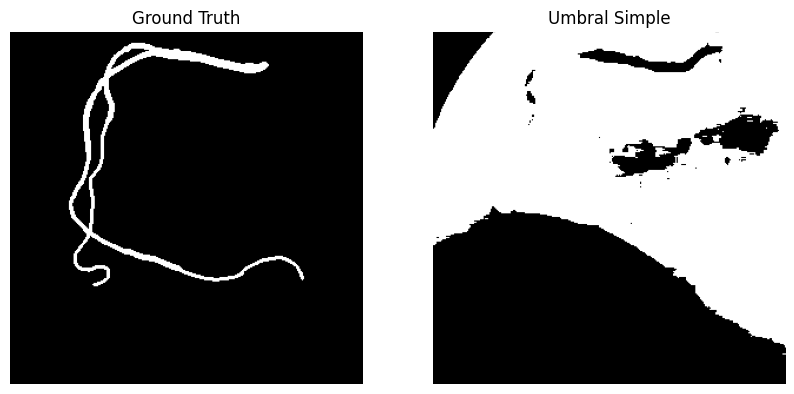

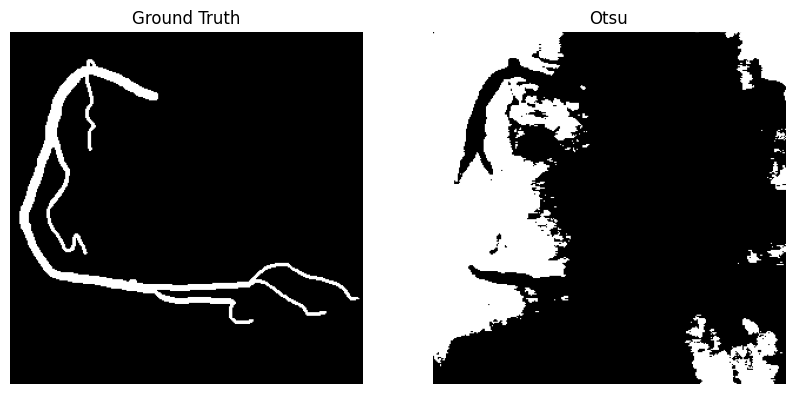

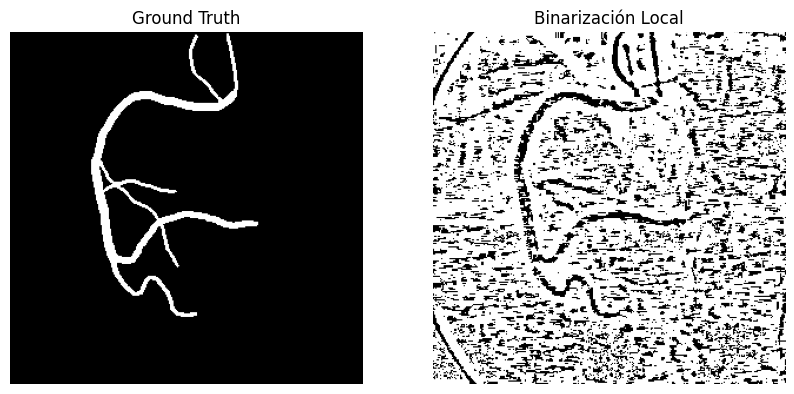

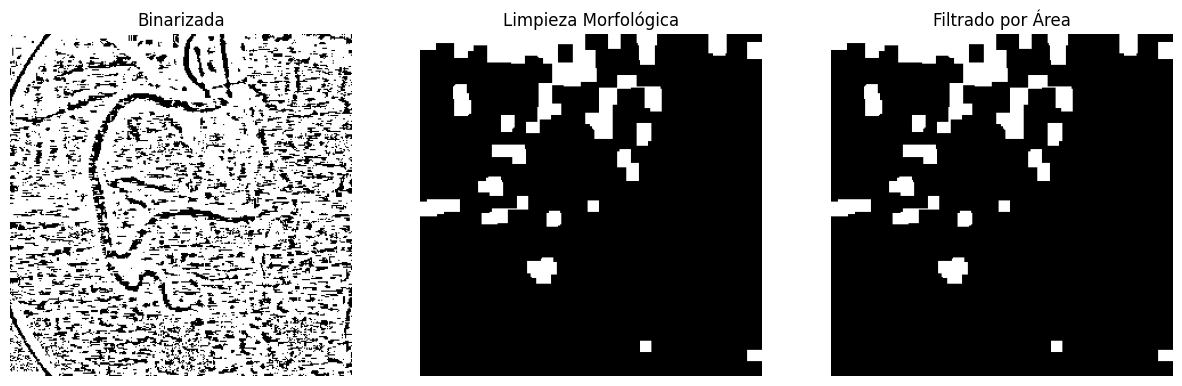

In [465]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2 as cv
from skimage import measure, morphology
import matplotlib.pyplot as plt

# Función para mostrar comparaciones
def mostrar_comparacion(imagenes_gt_paths, imagenes_pred, titulo):
    idx = random.randint(0, len(imagenes_gt_paths) - 1)
    imagen_gt_path = imagenes_gt_paths[idx]
    imagen_pred = imagenes_pred[idx]
    
    imagen_gt = cargar_imagen_p2(imagen_gt_path)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(imagen_gt, cmap='gray')
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')
    
    axs[1].imshow(imagen_pred, cmap='gray')
    axs[1].set_title(titulo)
    axs[1].axis('off')
    
    plt.show()

    if titulo == "Binarización Local":

        #imagen_float32 = imagen_pred.astype(np.float32)
        #imagen_suavizada = cv.bilateralFilter(imagen_float32, 30, 75, 75)


        # Aplicar apertura morfológica para eliminar ruido pequeño
        kernel = np.ones((2,2),np.uint8)  # El tamaño del kernel afecta la cantidad de ruido eliminado
        imagen_clean = cv.morphologyEx(imagen_pred, cv.MORPH_OPEN, kernel)

        # Aplicar cierre morfológico para cerrar pequeños huecos en las venas
        imagen_clean = cv.morphologyEx(imagen_clean, cv.MORPH_CLOSE, kernel)

        area_threshold = 50  # Ajusta esto según tus necesidades

        # Identificar componentes conectados
        label_img, num_labels = measure.label(imagen_clean, connectivity=2, return_num=True, background=0)
        props = measure.regionprops(label_img)

        # Filtrar componentes basados en el área
        filtered_image = np.zeros_like(imagen_clean, dtype=np.uint8)  # Imagen negra para empezar
        for prop in props:
            if prop.area > area_threshold:
                # Si el área de la mancha es mayor que el umbral, conservarla
                filtered_image[label_img == prop.label] = 1


        # Mostrar la imagen original, la imagen binarizada y la imagen después de limpieza
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(imagen_pred, cmap='gray')
        plt.title('Binarizada')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(imagen_clean, cmap='gray')
        plt.title('Limpieza Morfológica')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(filtered_image, cmap='gray')
        plt.title('Filtrado por Área')
        plt.axis('off')

        plt.show()

# Ejemplo de cómo visualizar las comparaciones
imagenes_gt_paths = [f"images/{i}_gt.pgm" for i in range(1, 21)]
mostrar_comparacion(imagenes_gt_paths, imagenes_pred_simple, "Umbral Simple")
mostrar_comparacion(imagenes_gt_paths, imagenes_pred_otsu, "Otsu")
mostrar_comparacion(imagenes_gt_paths, imagenes_pred_local, "Binarización Local")


In [464]:
#